### Задание 1:
### Можно ли отобрать наиболее значимые признаки из имеющихся с помощью PCA? Ответ объясните.

PCA - это способ уменьшения размерности данных, при котором сохраненяется максимальное количество информации. Признаки, которые мы получаем в результате уменьшения размерности РСА - это не те признаки, которые были изначально. 
С помощью РСА возможно получить новые оси-компоненты на основе старых признаков. Отбирать наиболее значимые признаки с помощью этого метода некорректно. 

### Задание 2:
### Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd(). Применить к данным на уроке и сравнить ответы.

In [2]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [3]:
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

In [4]:
X_ = X.astype(float)
rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по признаку
means = X_.mean(axis=0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for j in range(cols):
    for i in range(rows):
        X_[i, j] /= std[j]

In [5]:
# Найдем собственные векторы и собственные значения
covariance_matrix = X_.T.dot(X_)
eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# print('Собственные значения в порядке убывания:')
# for i in eig_pairs:
#     print(i[0])
    
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}\n'
      f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}\n')

# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Доля дисперсии, описываемая каждой из компонент 
[72.96244541329987, 22.850761786701774, 3.6689218892828777, 0.5178709107154775]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [6]:
def get_own_vector(X, k):
    U, D, V = np.linalg.svd(X)
    V = V.T[:, :k]
    return X@V, V

In [7]:
svd_z, svd_w = get_own_vector(X_, 2)
print(f'Матрица весов PCA_SVD:\n {svd_w}')

Матрица весов PCA_SVD:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


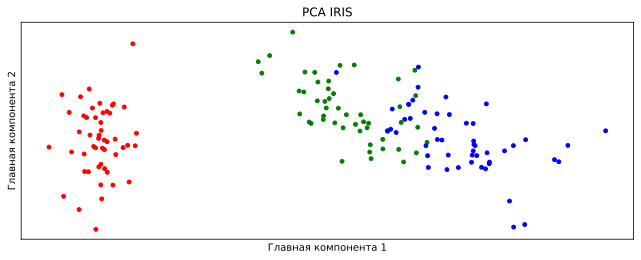

In [25]:
plt.figure(figsize=(11, 4))
y = iris.target
for c, i in zip('rgb', [0, 1, 2]):
    plt.scatter(svd_z[y==i, 0], svd_z[y==i, 1], c=c, s=15)
plt.xticks([])
plt.yticks([])
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA IRIS');

### Задание 3:
### Обучить любую модель классификации (из рассмотренных в курсе) на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

In [10]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [11]:
def e_metrics(x1, x2):

    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [12]:
X, y = load_iris(return_X_y=True)


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)


k = 100

y_pred_train = knn(X_train, y_train, X_train, k)
y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма на трейне при k = {k}: {accuracy(y_pred_train, y_train):.3f}')
print(f'Точность алгоритма на тесте при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма на трейне при k = 100: 0.500
Точность алгоритма на тесте при k = 100: 0.467


In [13]:
def standard_scale(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

In [14]:
# отмасштабируем выборку
X = X.astype(float)

X = standard_scale(X)

In [15]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X.T @ X

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(437.7746724797987, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654]))
(137.10457072021052, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199]))
(22.013531335697227, array([-0.71956635,  0.24438178,  0.14212637,  0.63427274]))
(3.107225464292844, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))


In [16]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[72.96244541329987, 22.850761786701778, 3.668921889282875, 0.5178709107154745]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


In [17]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack([eig_pairs[i][1].reshape(4,1) for i in range(2)])

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [18]:
# Сформируем новую матрицу "объекты-признаки"
Z = X.dot(W)

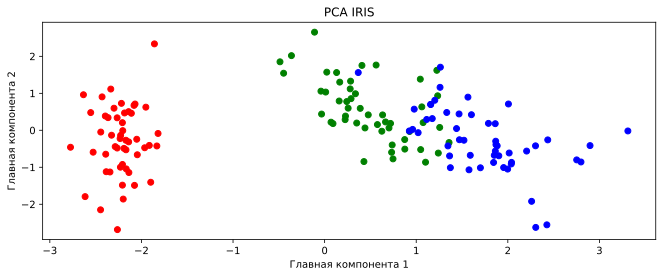

In [23]:
plt.figure(figsize=(11, 4))
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y == i, 0], Z[y == i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA IRIS')
plt.show()

In [21]:
Z_train, Z_test, y_z_train, y_z_test = train_test_split(Z, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

In [22]:
y_z_pred_train = knn(Z_train, y_z_train, Z_train, k)
y_z_pred = knn(Z_train, y_z_train, Z_test, k)

print(f'Точность алгоритма на трейне при k = {k}: {accuracy(y_z_pred_train, y_z_train):.3f}')
print(f'Точность алгоритма на тесте при k = {k}: {accuracy(y_z_pred, y_z_test):.3f}')

Точность алгоритма на трейне при k = 100: 0.675
Точность алгоритма на тесте при k = 100: 0.567


Вывод: точность повысилась, так как изначально модель была переобучена